In [1]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/share/proj'

In [2]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from skbio.stats.ordination import pcoa

from biota.util import assign_formations


%matplotlib inline

In [3]:
#Read in Excel Of Production Data
filename = 'Foraker 1207 Section 11 Lift Dates and Production July.xlsx'
xls = pd.ExcelFile(filename)

#Calculate number of wells (sheets) minus Legend, return wellnames
len(xls.sheet_names)-1
wellnames = xls.sheet_names
del wellnames[0]

import datetime
d = datetime.datetime.today()
currentdate = d.strftime('%d-%m-%Y')

In [8]:
#Define flowback file names
flowbackfiles = ['Foraker 1SMH.xlsm','Foraker 2UMH.xlsm','Foraker 3WH.xlsm','Foraker 4LMH.xlsm','Foraker 5WH.xlsm','Foraker 6UMH.xlsm'\
                 ,'Foraker 7SMH.xlsm','Foraker 8UMH.xlsm','Foraker 9LMH.xlsm','Foraker 10UMH.xlsm','Foraker 11SMH.xlsm']

In [9]:
#create dict of flowback and chokes
flowbackdf = {}
chokes = {}

#Read in Excel Of Floback Data for each well, create a dictionary of choke sizes to dates
for i,file in enumerate (flowbackfiles):
    filename = file
    sheetname = 'Daily Totals'
    well = wellnames[i]
    flowbackdf [well] = pd.read_excel(filename, sheet_name=sheetname ,index_col = 1,skiprows = 13,usecols = [1,2,3,4,5,6,7] )
    columns = ["DATE","AVG CSG","AVG CHOKE","DAILY OIL","DAILY SALES","DAILY GAS"]
    flowbackdf[well].columns = columns
    flowbackdf[well]['DATE'] =  pd.to_datetime(flowbackdf[well]['DATE'], format='%Y%b%d')
    chokes[well] = flowbackdf[well].set_index('DATE')['AVG CHOKE'].to_dict()


In [17]:
#Loop through sheets and create df for each
#Create dictionary of dataframes for each well, map choke values to prod dates in well df
filename = 'Foraker 1207 Section 11 Lift Dates and Production July.xlsx'
dfs = {}
for well in wellnames:
    wellsheet = well
    dfs[well] = pd.read_excel(filename, sheet_name=wellsheet)
    dfs[well]['Choke'] = dfs[well]['PERIOD'].map(chokes[well])
    dfs[well] = dfs[well]['LEASE', 'PERIOD', 'TP', 'CP', 'BH', 'GROSS OIL', 'GROSS WTR',
       'GROSS GAS', 'GROSS BOE', 'Downtime', 'Lift', 'Choke', 'Cum Prod',
       'Days Online']
    dfs[well].to_pickle("./JulyData/{}.pkl".format(well))

KeyError: ('LEASE', 'PERIOD', 'TP', 'CP', 'BH', 'GROSS OIL', 'GROSS WTR', 'GROSS GAS', 'GROSS BOE', 'Downtime', 'Lift', 'Choke', 'Cum Prod', 'Days Online')

In [ ]:
#Calculate Cums for Every Well, days online
for well in dfs:
    for i in range(len(dfs[well].index)):
        if i == 0:
                dfs[well].at[i,'Cum Prod'] = dfs[well].at[i,'GROSS OIL']
                dfs[well].at[i,'Days Online'] = 1
        else:
                deltadate = dfs[well]['PERIOD'].values[i] - dfs[well]['PERIOD'].values[i-1]
                day = deltadate.astype('timedelta64[D]').astype(int)
                if day == 1:
                    dfs[well].at[i,'Cum Prod'] = dfs[well].at[i-1,'Cum Prod'] + dfs[well].at[i,'GROSS OIL']
                    dfs[well].at[i,'Days Online'] = dfs[well].at[i-1,'Days Online'] + 1

In [17]:
#wellnames

In [19]:
d#fs

datetime.datetime(2019, 7, 15, 18, 47, 8, 485218)

In [1]:
#dfs['Foraker 1207 #1SMH-11']

In [14]:
#save DFS
dfs.to_pickle("./SavedData/WellData.pkl")

AttributeError: 'dict' object has no attribute 'to_pickle'

Creation of the directory /home/jovyan/Practice/Images/12-07-2019 failed


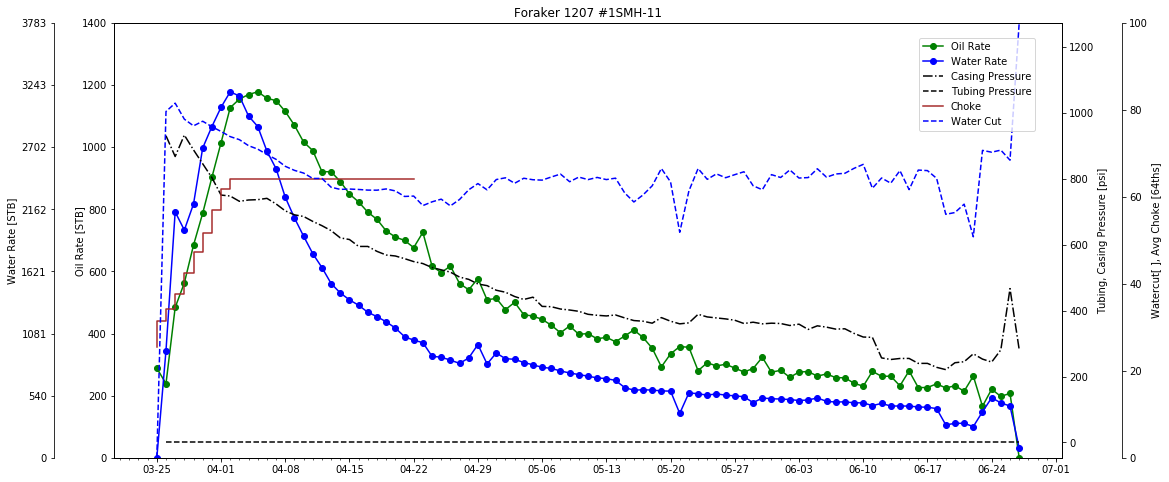

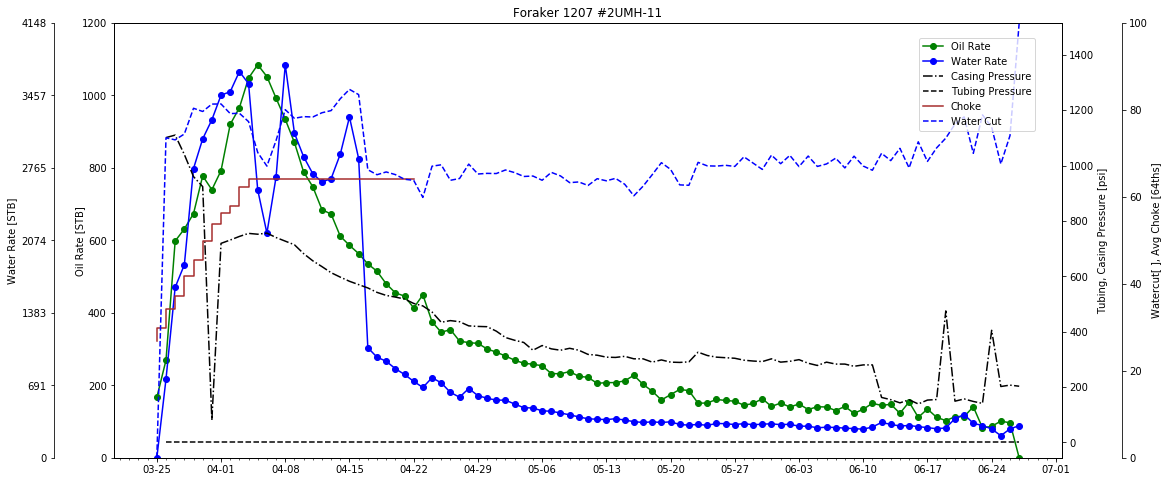

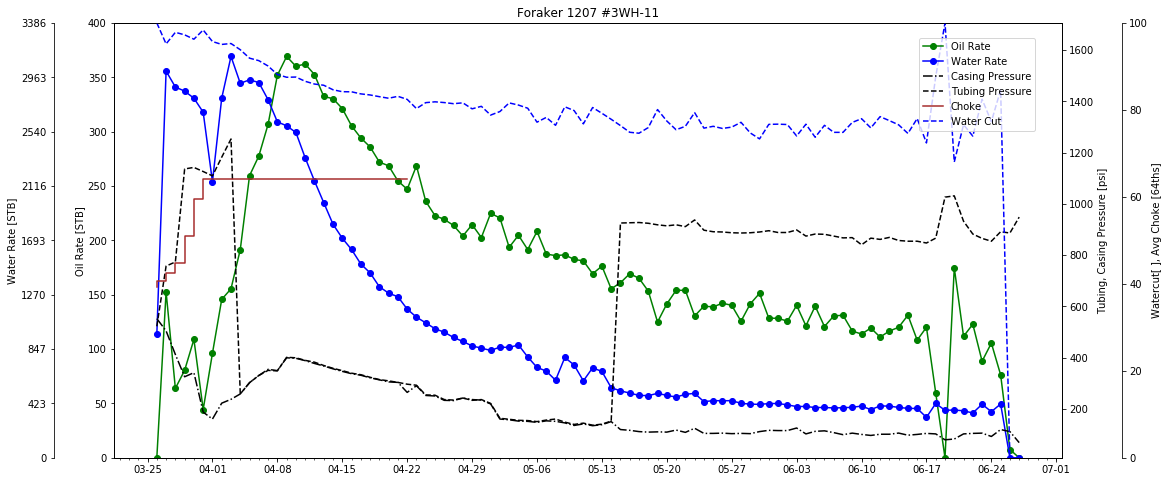

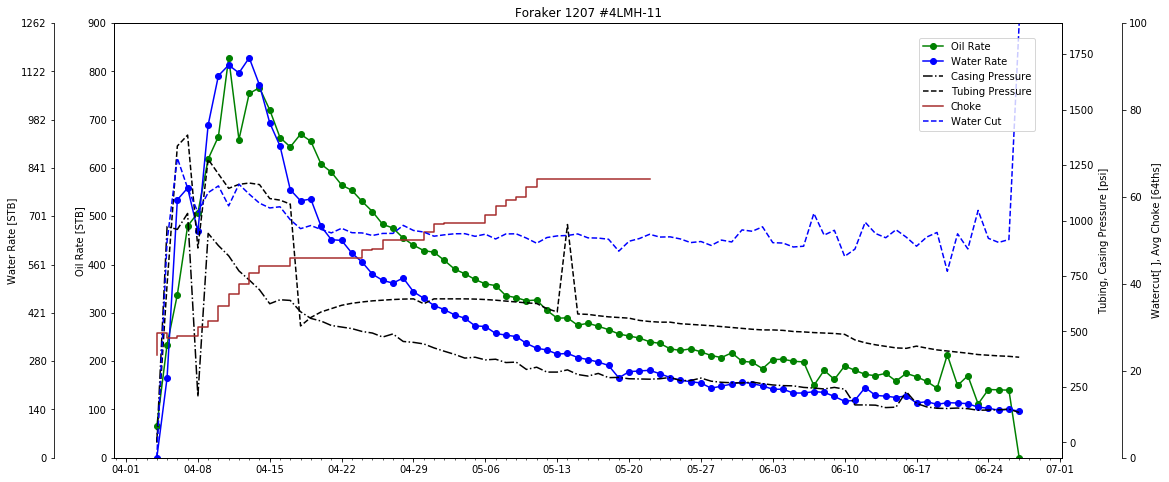

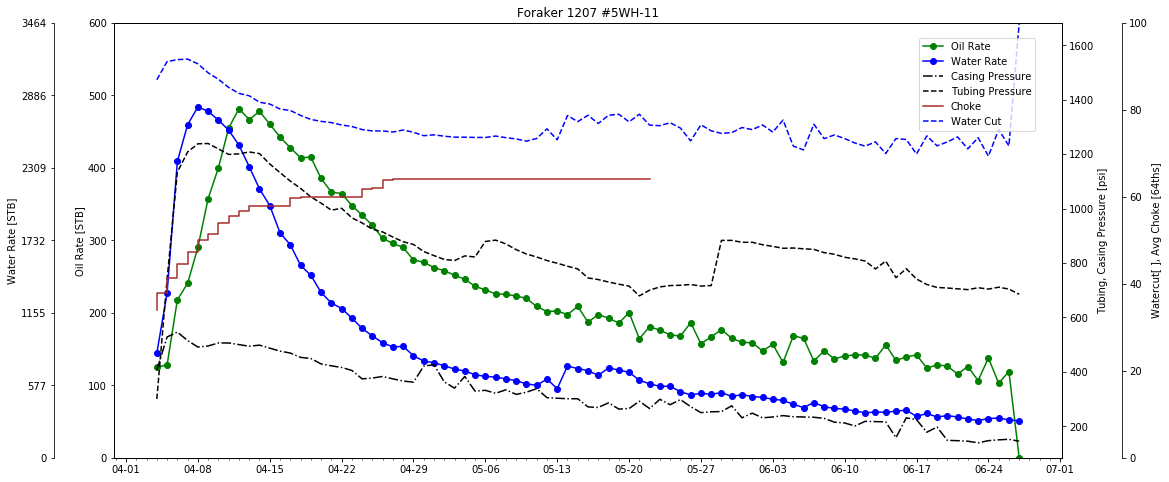

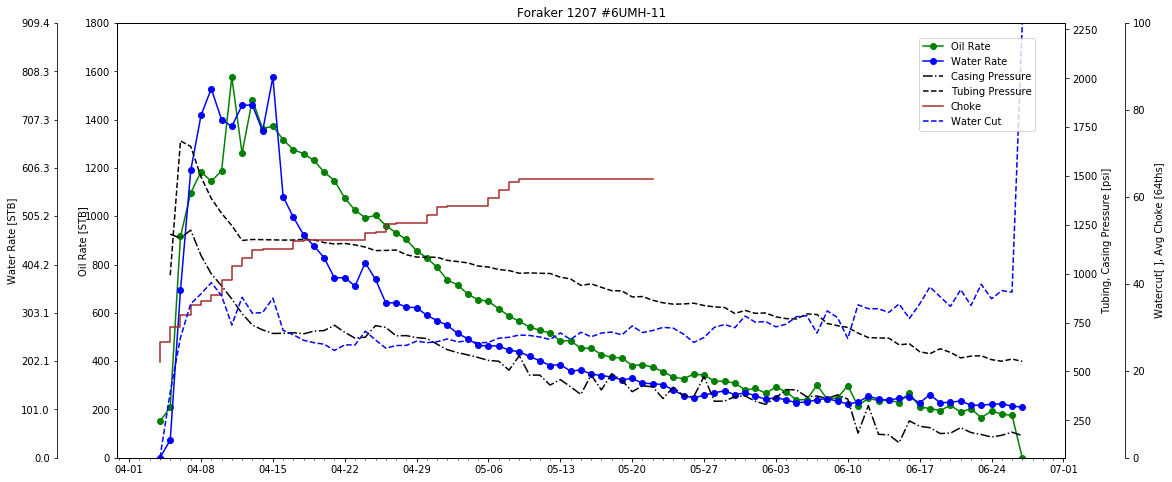

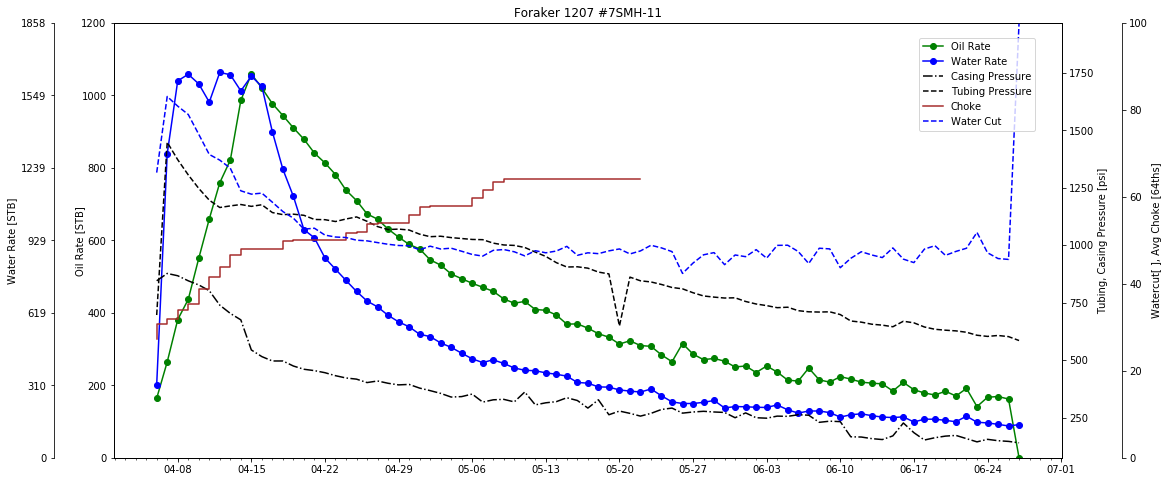

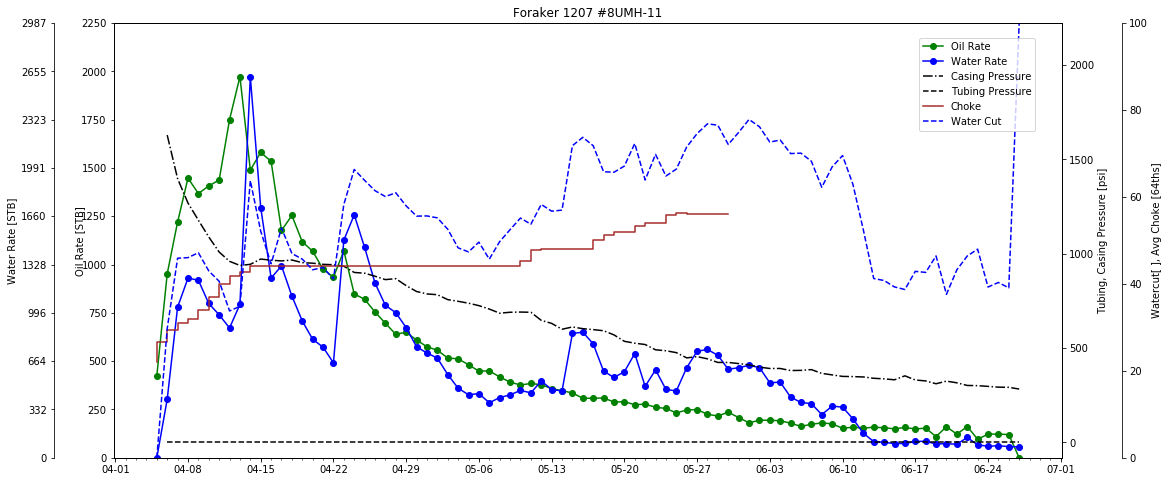

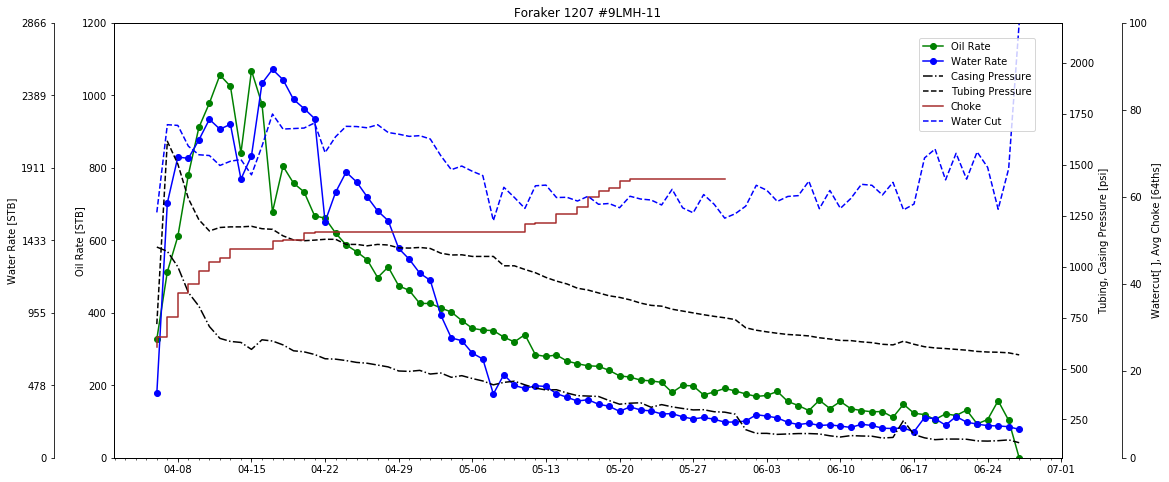

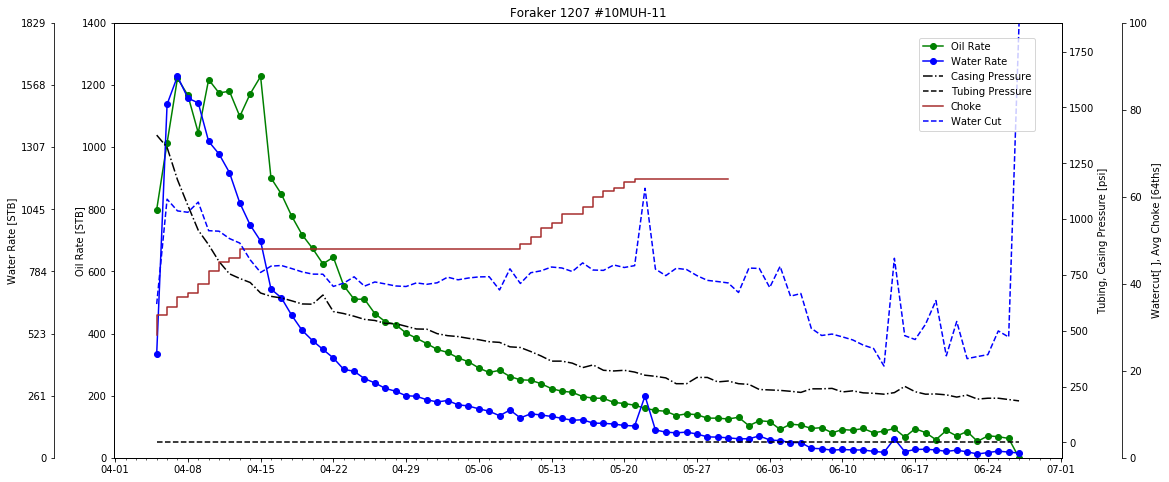

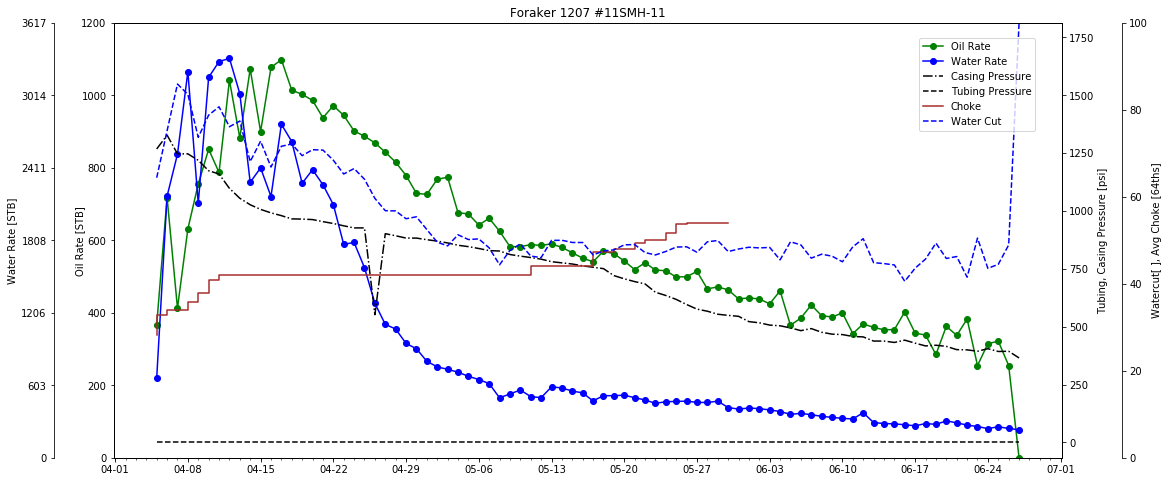

In [73]:
#Plot Production Plots

#Save images
dirpath = os.getcwd()
folderloc = dirpath + '/Images/'+ currentdate
    
try:  
     os.makedirs(folderloc)
except OSError:  
     print ("Creation of the directory %s failed" % folderloc)
else:  
        print ("Successfully created the directory %s" % folderloc)
            

#Loop through wells
for i,well in enumerate(dfs):
    
    #import relevant datetime and plotting modules
    from datetime import datetime
    import matplotlib.dates as mdates
    from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
    import matplotlib.ticker as ticker
    
    #Plot Production Data
    fig, ax = plt.subplots(1, figsize=(17,8))
    ax.plot(dfs[well].PERIOD, dfs[well]['GROSS OIL'],marker='o', c='green', label='Oil Rate')
    ax.set_title(wellnames[i])
    ax.set_ylabel('Oil Rate [STB]')
    ax.yaxis.set_label_coords(-0.03,0.5)
    ax.set_ylim(bottom=0)
    
    #Set axis parameters for second left axis
    par2 = ax.twinx()
    par2.spines['left'].set_position(('outward', 60))
    par2.yaxis.set_ticks_position('left')
    par2.set_ylabel('Water Rate [STB]')
    par2.yaxis.set_label_position("left")
    #Plot Data
    water = par2.plot(dfs[well].PERIOD, dfs[well]['GROSS WTR'], marker='o',c='blue', label='Water Rate')
    par2.set_ylim(bottom=0)
    #loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    #pars.yaxis.set_major_locator(loc)
    
    #Normalize Tick Intervals on Left Y axis
    y_min, y_max = ax.get_ylim()
    y2_min, y2_max = par2.get_ylim()
    ticks = [(tick - y_min)/(y_max - y_min) for tick in ax.get_yticks()]
    ticks2 = [tick * y2_max for tick in ticks]
    ticks3 = [tick * y_max for tick in ticks]
    par2.set_yticks(ticks2)
    ax.set_yticks(ticks3)
    
    #Plot Pressures
    ax2 = ax.twinx()
    ax2.plot(dfs[well].PERIOD, dfs[well]['CP'], linestyle = '-.', c='black', label='Casing Pressure')
    ax2.plot(dfs[well].PERIOD, dfs[well]['TP'], linestyle = '--', c='black', label='Tubing Pressure')
    ax2.set_ylabel('Tubing, Casing Pressure [psi]')
    ax2.yaxis.set_label_position("right")
    y_ax2min, y_ax2max = ax2.get_ylim()
    ax2.set_ylim(top = y_ax2max*1.3)
    
    #Set axis parameters for second right axis
    par3 = ax.twinx()
    par3.spines['right'].set_position(('outward', 60))
    par3.yaxis.set_ticks_position('right')
    par3.set_ylabel('Watercut[ ], Avg Choke [64ths]')
    par3.yaxis.set_label_position("right")
    #Plot Data
    choke = par3.step(dfs[well].PERIOD, dfs[well]['Choke'],c='brown', label='Choke')
    wct = par3.plot(dfs[well].PERIOD, (100*dfs[well]['GROSS WTR']/(dfs[well]['GROSS OIL']+dfs[well]['GROSS WTR'])),\
                    linestyle = '--', c='blue',label='Water Cut')
    par3.set_ylim(bottom=0)
    par3.set_ylim(top=100)
    
    #Normalize Tick Intervals on Right Y axis
    y_ax2min, y_ax2max = ax2.get_ylim()
    ypar3_min, ypar3_max = par3.get_ylim()
    ticks_r = [(tick - ypar3_min)/(ypar3_max - ypar3_min) for tick in par3.get_yticks()]
    #ticks2_r = [tick * y2_max for tick in ticks]
    ticks3_r = [tick * y_ax2max for tick in ticks_r]
    #par2.set_yticks(ticks2)
   # ax2.set_yticks(ticks3_r)
    
    #Add legends
    fig.legend(bbox_to_anchor=(0.35, 0.28, 0.5, 0.5))
    
    #Reformat Date Series
    #Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
    days = mdates.DayLocator()
    myFmt = mdates.DateFormatter("%m-%d")
    weeks = mdates. WeekdayLocator(byweekday=MO)
    #Assign ticks
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(myFmt)
    
    #Save Image
    imageloc = folderloc +'/' + well +'.png'
    fig.savefig(imageloc, dpi=1000, bbox_inches='tight')
        

In [12]:
folderloc = dirpath + '/Images/'+ currentdate

NameError: name 'dirpath' is not defined

In [13]:
folderloc

NameError: name 'folderloc' is not defined

In [14]:
#len(sampledf.index)

In [160]:
#Add formations each well

#dfs = {}
#for well in wellnames:
#    wellsheet = well
#    dfs[well] = pd.read_excel(filename, sheet_name=wellsheet)
#    dfs[well]['Formation'] = dfs[well]['Formation'].map(welltargets[well])
    
#welltargets= {'w1.alpha': 'red',
#                                'w2.alpha': 'pink',
#                                'shale.alpha':'orange',
##                                'upper.beta': 'blue',
#                                'middle.beta': 'green',
#                                'lower.beta': 'purple',
#                                'upper.delta':'black'}

In [12]:
#wellnames

In [22]:
dfs['Foraker 1207 #6UMH-11'].head()

,LEASE,PERIOD,TP,CP,BH,GROSS OIL,GROSS WTR,GROSS GAS,GROSS BOE,GROSS NGL,...,NET WTR,NET GAS,NET BOE,Downtime,Lift,Prod Date,New Lift Date,Choke,Cum Prod,Days Online
0,FORAKER 1207 6UMH-11,2019-04-04,NaN,NaN,NaN,150.38,0,0,150.3800,NaN,...,0,0.000000,89.278257,0,FLOW,2019-04-04,2019-04-04,22.000000,150.38,1.0
1,FORAKER 1207 6UMH-11,2019-04-05,992.0,1202.0,4259.0,208.87,37,185,239.7033,NaN,...,37,109.831610,142.308105,0,FLOW,2019-04-05,2019-04-04,26.666667,359.25,2.0
2,FORAKER 1207 6UMH-11,2019-04-06,1679.0,1182.0,4115.0,916.25,350,461,993.0833,NaN,...,350,273.688499,589.578043,0,FLOW,2019-04-06,2019-04-04,30.000000,1275.50,3.0
3,FORAKER 1207 6UMH-11,2019-04-07,1651.0,1223.0,3828.0,1096.56,601,1191,1295.0600,NaN,...,601,707.078097,768.856893,0,FLOW,2019-04-07,2019-04-04,32.750000,2372.06,4.0
4,FORAKER 1207 6UMH-11,2019-04-08,1495.0,1093.0,3581.0,1183.60,716,1629,1455.1000,NaN,...,716,967.111855,863.870141,0,FLOW,2019-04-08,2019-04-04,35.166667,3555.66,5.0


In [10]:
#Define colours based on landing zone
#UM = []

In [8]:
finaldfs = {}
for well in wellnames:
    #print(well)
    #wellsheet = well
    #finaldfs[well] = pd.read_excel(filename, sheet_name=wellsheet)
    #finaldfs[well]['Choke'] = dfs[well]['PERIOD'].map(chokes[well])
    dfs[well].to_pickle("./JulyData/{}.pkl".format(well))

In [1]:
#finaldfs['Foraker 1207 #6UMH-11']['Days Online'].head()

In [13]:
#Define well markers and colours for plotting
wellcolours = {'Foraker 1207 #1SMH-11':'green','Foraker 1207 #2UMH-11':'lightseagreen','Foraker 1207 #3WH-11':'darkgreen',\
               'Foraker 1207 #4LMH-11':'darkslategray','Foraker 1207 #5WH-11':'darkgreen','Foraker 1207 #6UMH-11':'lightseagreen',\
              'Foraker 1207 #7SMH-11':'green','Foraker 1207 #8UMH-11':'lightseagreen','Foraker 1207 #9LMH-11':'darkslategray',\
               'Foraker 1207 #10MUH-11':'lightseagreen','Foraker 1207 #11SMH-11':'green'}
wellmarkers = {'Foraker 1207 #1SMH-11':'1','Foraker 1207 #2UMH-11':'v','Foraker 1207 #3WH-11':'D',\
               'Foraker 1207 #4LMH-11':'s','Foraker 1207 #5WH-11':'d','Foraker 1207 #6UMH-11':'^',\
              'Foraker 1207 #7SMH-11':'+','Foraker 1207 #8UMH-11':'<','Foraker 1207 #9LMH-11':'P',\
               'Foraker 1207 #10MUH-11':'>','Foraker 1207 #11SMH-11':'x'}

Creation of the directory /home/jovyan/Practice/Images/12-07-2019 failed


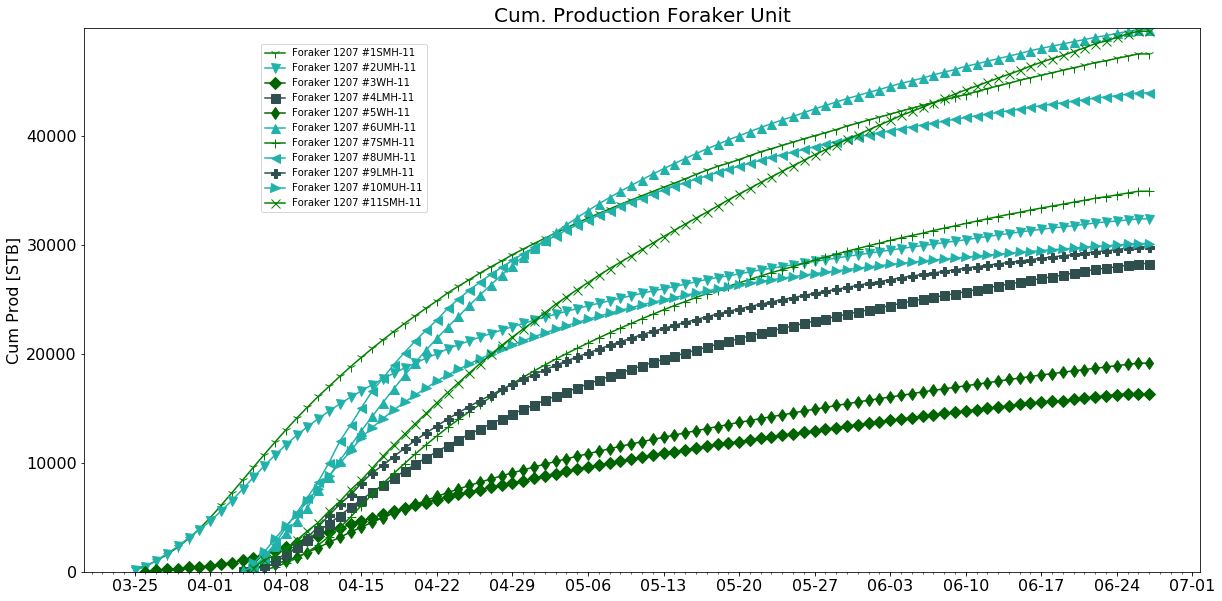

In [72]:
#Plot Cums for every well

#Save images
dirpath = os.getcwd()
folderloc = dirpath + '/Images/'+ currentdate
    
try:  
     os.makedirs(folderloc)
except OSError:  
     print ("Creation of the directory %s failed" % folderloc)
else:  
        print ("Successfully created the directory %s" % folderloc)
            
#Loop through wells
fig, ax = plt.subplots(1, figsize=(20,10))
for i,well in enumerate(dfs):
    
    #import relevant datetime and plotting modules
    from datetime import datetime
    import matplotlib.dates as mdates
    from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
    import matplotlib.ticker as ticker
    
    #Plot Cum Data
    ax.plot(dfs[well].PERIOD, dfs[well]['Cum Prod'],marker=wellmarkers[wellnames[i]],ms = 9,c=wellcolours[wellnames[i]], label = wellnames[i])
    ax.set_ylabel('Cum Prod [STB]',fontsize = 16)
    ax.set_ylim(bottom=0)
    ax.set_title('Cum. Production Foraker Unit',fontsize = 20)
    #Reformat Date Series
    #Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
    days = mdates.DayLocator()
    myFmt = mdates.DateFormatter("%m-%d")
    weeks = mdates. WeekdayLocator(byweekday=MO)
    #Assign ticks
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis="both", labelsize=16)
    
#fig.legend(bbox_to_anchor = (0,0))
#loc = 'upper left'
fig.legend(bbox_to_anchor = (0.3,0.78))
#Save Image
#Save images
# dirpath = os.getcwd()
path = '/home/jovyan/Practice/Images/'
#folderloc = dirpath + '/Images/'
    
imageloc = path +'Cum Prod'+'.png'
fig.savefig(imageloc, dpi=300)

Creation of the directory /home/jovyan/Practice/Images/12-07-2019 failed


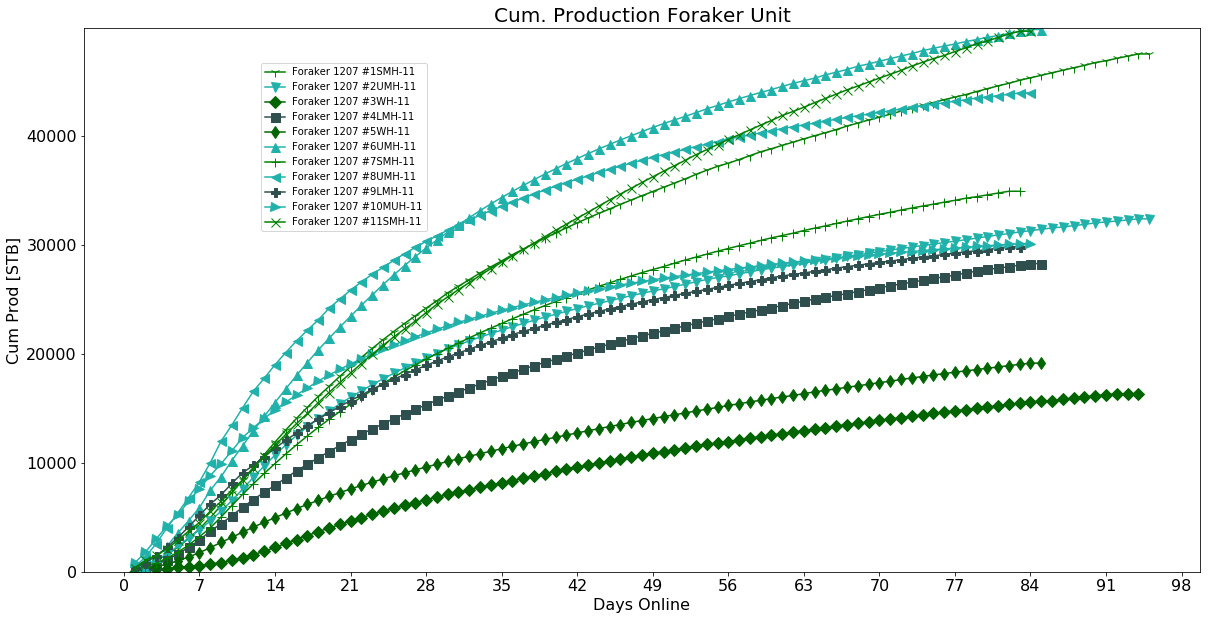

In [71]:
#Plot Cums for every well

#Save images
dirpath = os.getcwd()
folderloc = dirpath + '/Images/'+ currentdate
    
try:  
     os.makedirs(folderloc)
except OSError:  
     print ("Creation of the directory %s failed" % folderloc)
else:  
        print ("Successfully created the directory %s" % folderloc)
            
#Loop through wells
fig, ax = plt.subplots(1, figsize=(20,10))
for i,well in enumerate(dfs):
    
    #import relevant datetime and plotting modules
    from datetime import datetime
    import matplotlib.dates as mdates
    from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
    import matplotlib.ticker as ticker
    
    #Plot Cum Data
    ax.plot(dfs[well]['Days Online'], dfs[well]['Cum Prod'],marker=wellmarkers[wellnames[i]],ms = 9,c=wellcolours[wellnames[i]], label = wellnames[i])
    ax.set_ylabel('Cum Prod [STB]',fontsize = 16)
    ax.set_xlabel('Days Online',fontsize = 16)
    ax.set_ylim(bottom=0)
    ax.set_title('Cum. Production Foraker Unit',fontsize = 20)
    start, end = ax.get_xlim()
    stepsize = 7
    ax.xaxis.set_ticks(np.arange(0, end, stepsize))
    ax.tick_params(axis="both", labelsize=16)
    
#fig.legend(bbox_to_anchor = (0loc = 'upper left',0))
fig.legend(bbox_to_anchor = (0.3,0.78))
path = '/home/jovyan/Practice/Images/'
imageloc = path +'Cum Prod Days Online'+'.png'
fig.savefig(imageloc, dpi=300)

In [209]:
print(ax.get_xlim())

(-3.7, 99.7)


In [18]:
range(2)

range(0, 2)

In [20]:
for i in range(2):
    print(i)

0
1


In [2]:
dfs

NameError: name 'dfs' is not defined

In [16]:
wellnames

['Foraker 1207 #1SMH-11',
 'Foraker 1207 #2UMH-11',
 'Foraker 1207 #3WH-11',
 'Foraker 1207 #4LMH-11',
 'Foraker 1207 #5WH-11',
 'Foraker 1207 #6UMH-11',
 'Foraker 1207 #7SMH-11',
 'Foraker 1207 #8UMH-11',
 'Foraker 1207 #9LMH-11',
 'Foraker 1207 #10MUH-11',
 'Foraker 1207 #11SMH-11']

In [ ]:
# Make a comparative 

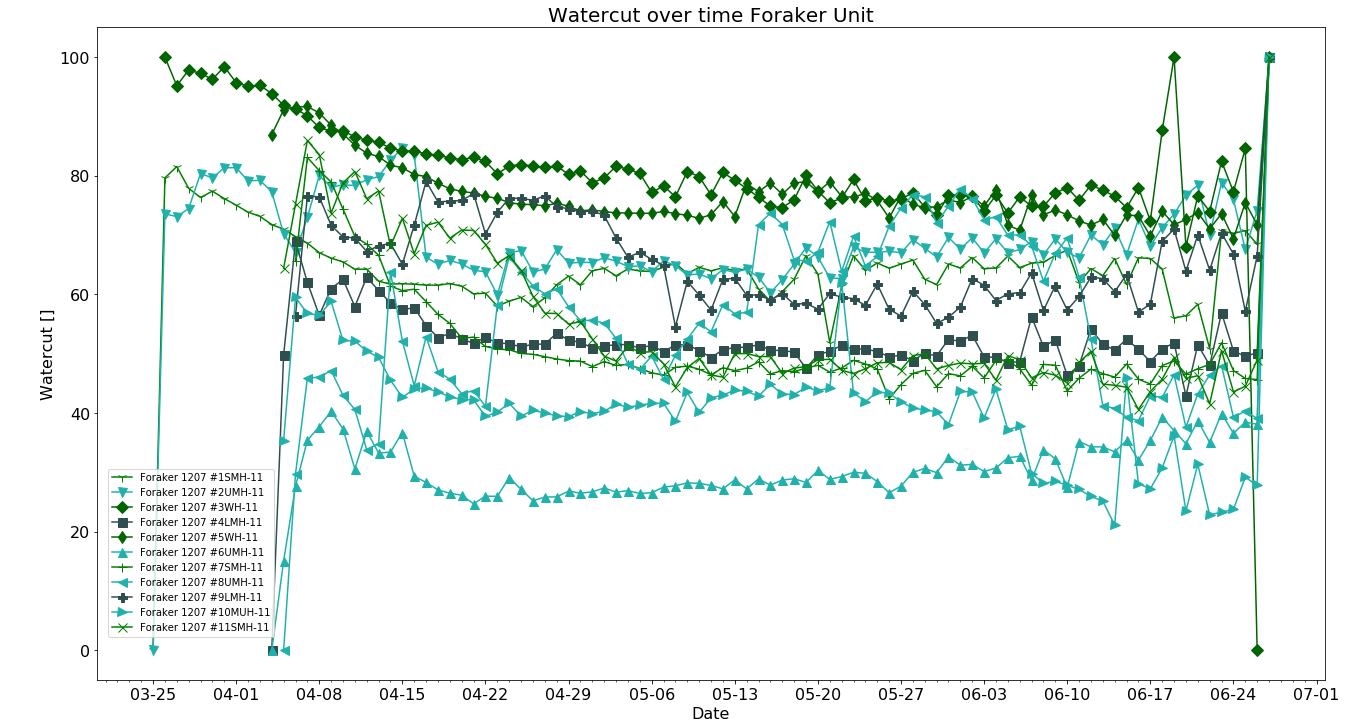

In [55]:
#Plot Watercut vs time
fig2, ax = plt.subplots(1, figsize=(22,12))
for i,well in enumerate(dfs):
    #WCT over time
    #ax.plot(dfs[well].PERIOD, dfs[well]['CP'], linestyle = '-.', c='black', label='Casing Pressure')
    ax.plot(dfs[well].PERIOD, (100*dfs[well]['GROSS WTR']/(dfs[well]['GROSS OIL']+dfs[well]['GROSS WTR'])),\
                   marker=wellmarkers[wellnames[i]],ms = 9,c=wellcolours[wellnames[i]], label = wellnames[i])
    ax.set_ylabel('Watercut []',fontsize = 16)
    ax.set_xlabel('Date',fontsize = 16)
   # ax.set_ylim(bottom=0)
    ax.set_title('Watercut over time Foraker Unit',fontsize = 20)
    days = mdates.DayLocator()
    myFmt = mdates.DateFormatter("%m-%d")
    weeks = mdates. WeekdayLocator(byweekday=MO)
    #Assign ticks
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis="both", labelsize=16)
    
fig2.legend(loc = 'lower left',bbox_to_anchor = (0.065,0.1))
imageloc = path +'Watercut Foraker'+'.png'
fig2.savefig(imageloc, dpi=300)

In [1]:
#Plot Watercut vs Days Online
fig3, ax = plt.subplots(1, figsize=(22,12))
for i,well in enumerate(dfs):
    #WCT over time
    #ax.plot(dfs[well].PERIOD, dfs[well]['CP'], linestyle = '-.', c='black', label='Casing Pressure')
    ax.plot(dfs[well]['Days Online'], (100*dfs[well]['GROSS WTR']/(dfs[well]['GROSS OIL']+dfs[well]['GROSS WTR'])),\
                   marker=wellmarkers[wellnames[i]],ms = 9,c=wellcolours[wellnames[i]], label = wellnames[i])
    ax.set_ylabel('Watercut []',fontsize = 16)
    ax.set_xlabel('Days Online',fontsize = 16)
   # ax.set_ylim(bottom=0)
    ax.set_title('Watercut over days online Foraker Unit',fontsize = 20)
    start, end = ax.get_xlim()
    stepsize = 7
    ax.xaxis.set_ticks(np.arange(0, end, stepsize))
    ax.tick_params(axis="both", labelsize=16)
    
fig3.legend(loc = 'lower left',bbox_to_anchor = (0.065,0.065))
imageloc = path +'Watercut vs Days Online Foraker'+'.png'
fig3.savefig(imageloc, dpi=300)

NameError: name 'plt' is not defined

In [85]:
deltat = dfs['Foraker 1207 #8UMH-11']['PERIOD'].values[2] - dfs['Foraker 1207 #8UMH-11']['PERIOD'].values[1]